# Technical Challenge: Salary Prediction

# Introduction


Develop a predictive model (using Python) to forecast an individual's salary based on a given dataset.

• Context: the data corresponds to a public dataset, and it includes information about their age,
gender, education level, job title, years of experience and description. Using this data, it should
be possible to predict (approximately) an employee's salary based on these variables.

You will be given a CSV file containing the data, and you should write the code to read from that file.

Moreover, you should design and implement a predictive model to forecast salaries, including all
necessary preprocessing steps, feature engineering, and model evaluation logic.

The model should be
trained and tested on the provided dataset.

The repo's README should contain relevant context and
necessary information to understand the predictive model and the steps taken during the development
process.

Mandatory Features:
• Load and preprocess the dataset using Pandas / Polars or similar tools.

• Perform feature transformations on the input dataset to derive useful numerical features from the model.

• Develop a predictive model using a machine learning library such as Scikit-learn or TensorFlow/Keras.

• Evaluate the model's performance using appropriate metrics. Explaining why that metric was useful.

• Compare the model results against a sensible baseline – e.g. a DummyRegressor

• All the metrics should be reported as intervals, not as single estimates. See references on how to calculate confidence intervals for ML.

• Structure the code in modules . See the reference to know what is expected.

• Present the final result in a Jupyter Notebook which should:
o Have a Table of Contents at the top.
o Contain explanatory text in markdown, properly formatted.
o Have no big blocks of code, instead it should import the functionality from the modules and only have initial configuration.
o Include illustrations or images showing the results.

Optional Features (include at least 1):
1. Explain the assumptions of the model used and validate if they are met.
2. Perform hyperparameter tuning to optimize the model's performance – e.g. Optuna.
3. Validate the model using cross-validation techniques.
4. Visualize the relationships between features and the target variable.
5. Use an interpretation tool to explain the contribution of each feature - e.g. SHAP
6. Use a more advanced model such as Random Forest, or Neural Networks.
7. Use multiple models and combine their outputs (e.g. Bagging, Boosting, Voting).
8. Lock your dependencies - e.g., using pipenv, uv or pdm.
9. Create a simple REST API for salary predictions - e.g. FastAPI.
10. Create a simple UI for salary predictions - e.g. Streamlit, Gradio, Taipy.
11. Save model predictions in a SQL Database - e.g. SQLite.
12. Use an Experiment Tracking tool - e.g. Weights and Biases, Neptune, MLFlow, Tensorboard.
13. Implement a Drift Detection technique and simulate a failure - e.g. Frouros.
14. Use version control for datasets - e.g. DVC.
15. Create anonymized datasets based on the given dataset - e.g. Synthetic Data Vault (SDV).
16. Use an interactive data visualization tool - e.g. Altair.
17. Add Unit tests for the project – e.g. Pytest.
18. Use typed dataframes – e.g. Pandera
19. Use calibration techniques in the model validation.

Evaluation criteria:
The project will be evaluated in five dimensions:

• Model design: how the predictive model is structured, the choice of features, model parameters, etc.

• Best practices: a code review to evaluate best practices, patterns, and overall design.

• Complexity: the level of optional features implemented and how they were incorporated into the development process.

• Organization: the most important aspect is to have something functional by the deadline; the
candidate should be able to organize themselves and deliver something valuable.

• Innovation: new features outside of what has been asked are a plus.

Import necessary libraries

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!pip install optuna

In [58]:
import sys
sys.path.append('/content/drive/MyDrive/Predictor de Salarios/')

# Data processing libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

# Scientific computing & ML libraries
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

# Local application imports
from src.utils import (load_data,
                      missing_data_table,
                      percentage_rows_missing_data)
from src.visualization import boxplots, scatterplot, create_plots, plot_shap_feature_importance
from src.preprocessing import merge_datasets, build_pipeline
from src.model import train_model
from src.evaluate import (bootstrap_metrics,
                         evaluate_model_with_baseline)

# Data Loading

Load datasets

In [59]:
descriptions = load_data('/content/drive/MyDrive/Predictor de Salarios/data/data/descriptions.csv')
people = load_data('/content/drive/MyDrive/Predictor de Salarios/data/data/people.csv')
salaries = load_data('/content/drive/MyDrive/Predictor de Salarios/data/data/salary.csv')

# EDA

Perform exploratory data analysis

## Descriptive Analysis

In [60]:
descriptions.head()

,id,Description
0,0,I am a 32-year-old male working as a Software ...
1,1,I am a 28-year-old data analyst with a Master'...
2,2,I am a 45-year-old Senior Manager with a PhD a...
3,3,I am a 36-year-old female Sales Associate with...
4,4,I am a 52-year-old male with over two decades ...


In [61]:
descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           375 non-null    int64 
 1   Description  372 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


This dataset contains personal summaries of 375 individuals. Each entry includes a unique ID and a short, free-text description. The descriptions usually mention the person's age, gender, job title, level of education, and sometimes their work experience. For example, a typical entry might read: "I am a 28-year-old data analyst with a Master's degree in Economics."

There are a few missing descriptions—specifically, 3 out of the 375 entries don't have any text in the description field.

In [62]:
people.head()

,id,Age,Gender,Education Level,Job Title,Years of Experience
0,0,32.0,Male,Bachelor's,Software Engineer,5.0
1,1,28.0,Female,Master's,Data Analyst,3.0
2,2,45.0,Male,PhD,Senior Manager,15.0
3,3,36.0,Female,Bachelor's,Sales Associate,7.0
4,4,52.0,Male,Master's,Director,20.0


In [63]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   375 non-null    int64  
 1   Age                  370 non-null    float64
 2   Gender               370 non-null    object 
 3   Education Level      370 non-null    object 
 4   Job Title            370 non-null    object 
 5   Years of Experience  373 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.7+ KB


In [64]:
people.describe()

,id,Age,Years of Experience
count,375.000000,370.000000,373.000000
mean,187.000000,37.437838,10.030831
std,108.397417,7.080465,6.557007
min,0.000000,23.000000,0.000000
25%,93.500000,31.250000,4.000000
50%,187.000000,36.000000,9.000000
75%,280.500000,44.000000,15.000000
max,374.000000,53.000000,25.000000


This dataset includes structured demographic and professional information for 375 individuals. Each person is identified by a unique ID and has associated data on age, gender, education level, job title, and years of work experience.

The majority of the records are complete, but a few entries have missing values—specifically, five are missing age, gender, education, or job title, and two are missing years of experience.

Age ranges from 23 to 53, with an average around 37.

Years of Experience varies between 0 and 25 years, with a median of about 9.

Job titles include roles like Software Engineer, Data Analyst, Senior Manager, and Director.

Education levels range from Bachelor’s to PhD.

In [65]:
salaries.head()

,id,Salary
0,0,90000.0
1,1,65000.0
2,2,150000.0
3,3,60000.0
4,4,200000.0


In [66]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      375 non-null    int64  
 1   Salary  373 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.0 KB


This dataset contains salary information for 375 individuals, each matched by a unique ID. The salary figures are numerical and represent annual income in dollars.

Most entries have a valid salary, though two records are missing this value. Salaries in the dataset vary widely, ranging from entry-level earnings to high-paying executive positions—examples include 60,000 for a Sales Associate and up to $200,000 for a Director-level role.

This data is intended to be combined with demographic and job-related information from the other datasets for a more complete analysis.

## Merge datasets

We will merge the three datasets based on the column 'id', common in all the datasets.

In [67]:
df = merge_datasets(descriptions, people, salaries)

In [68]:
df.head()

,id,Age,Gender,Education Level,Job Title,Years of Experience,Description,Salary
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,I am a 32-year-old male working as a Software ...,90000.0
1,1,28.0,Female,Master's,Data Analyst,3.0,I am a 28-year-old data analyst with a Master'...,65000.0
2,2,45.0,Male,PhD,Senior Manager,15.0,I am a 45-year-old Senior Manager with a PhD a...,150000.0
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,I am a 36-year-old female Sales Associate with...,60000.0
4,4,52.0,Male,Master's,Director,20.0,I am a 52-year-old male with over two decades ...,200000.0


## Missing Values

We’ve already noticed some missing values across the individual datasets. Now that we’ve merged them, it’s time to take a closer look at these gaps and decide how best to handle them.

After merging, we might find that a row missing data in one dataset has useful information in another. Now, we coudl drop the row with missing values or maybe fill in the missing values.

A good starting point is to assess how many rows contain missing data across the entire merged dataset. A common rule of thumb in data analysis is tha dropping less than 5% of the dataset is generally considered safe.

Losing a small fraction (e.g., <5%) usually won’t significantly impact the analysis or model performance—especially if the missing data is random. In fact, dropping these rows can often be safer than filling them with potentially misleading values.

Why be cautious with imputation?

- Filling in age with a mean or median may not reflect the actual distribution and could misrepresent the data.
- Filling in salary with an average can distort the income distribution and lead to incorrect assumptions.

Therefore, when the missing data:

- Is **random** (i.e., not concentrated in a specific group),
- Represents a **small portion** of the dataset, and
- Comes from a **sufficiently large sample**,

then dropping the affected rows is often the simplest and most reliable approach.


In [69]:
missing_data_table(df)

,NaN Count,NaN Percentage (%)
id,0,0.00
Age,5,1.33
Gender,5,1.33
Education Level,5,1.33
Job Title,5,1.33
Years of Experience,2,0.53
Description,3,0.80
Salary,2,0.53


In [70]:
percentage = percentage_rows_missing_data(df)
print(f"Percentage of rows with at least one missing value: {percentage:.2f}%")

Percentage of rows with at least one missing value: 4.53%


We see that the overall Percentage of rows with at least one missing value is slightly lower than 5%.

Now, let's check if the missing data is random or has a pattern. We'll do that with two graphs:

- Matrix: shows where missing values are. Each column represents a variable and each row represents a person (or entry in the dataset). The white bars show where the missing data is.

- Heatmap: helps you see if missing values tend to happen together. This heatmap does not show the correlation of the actual values, but the correlation between the missing data.

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


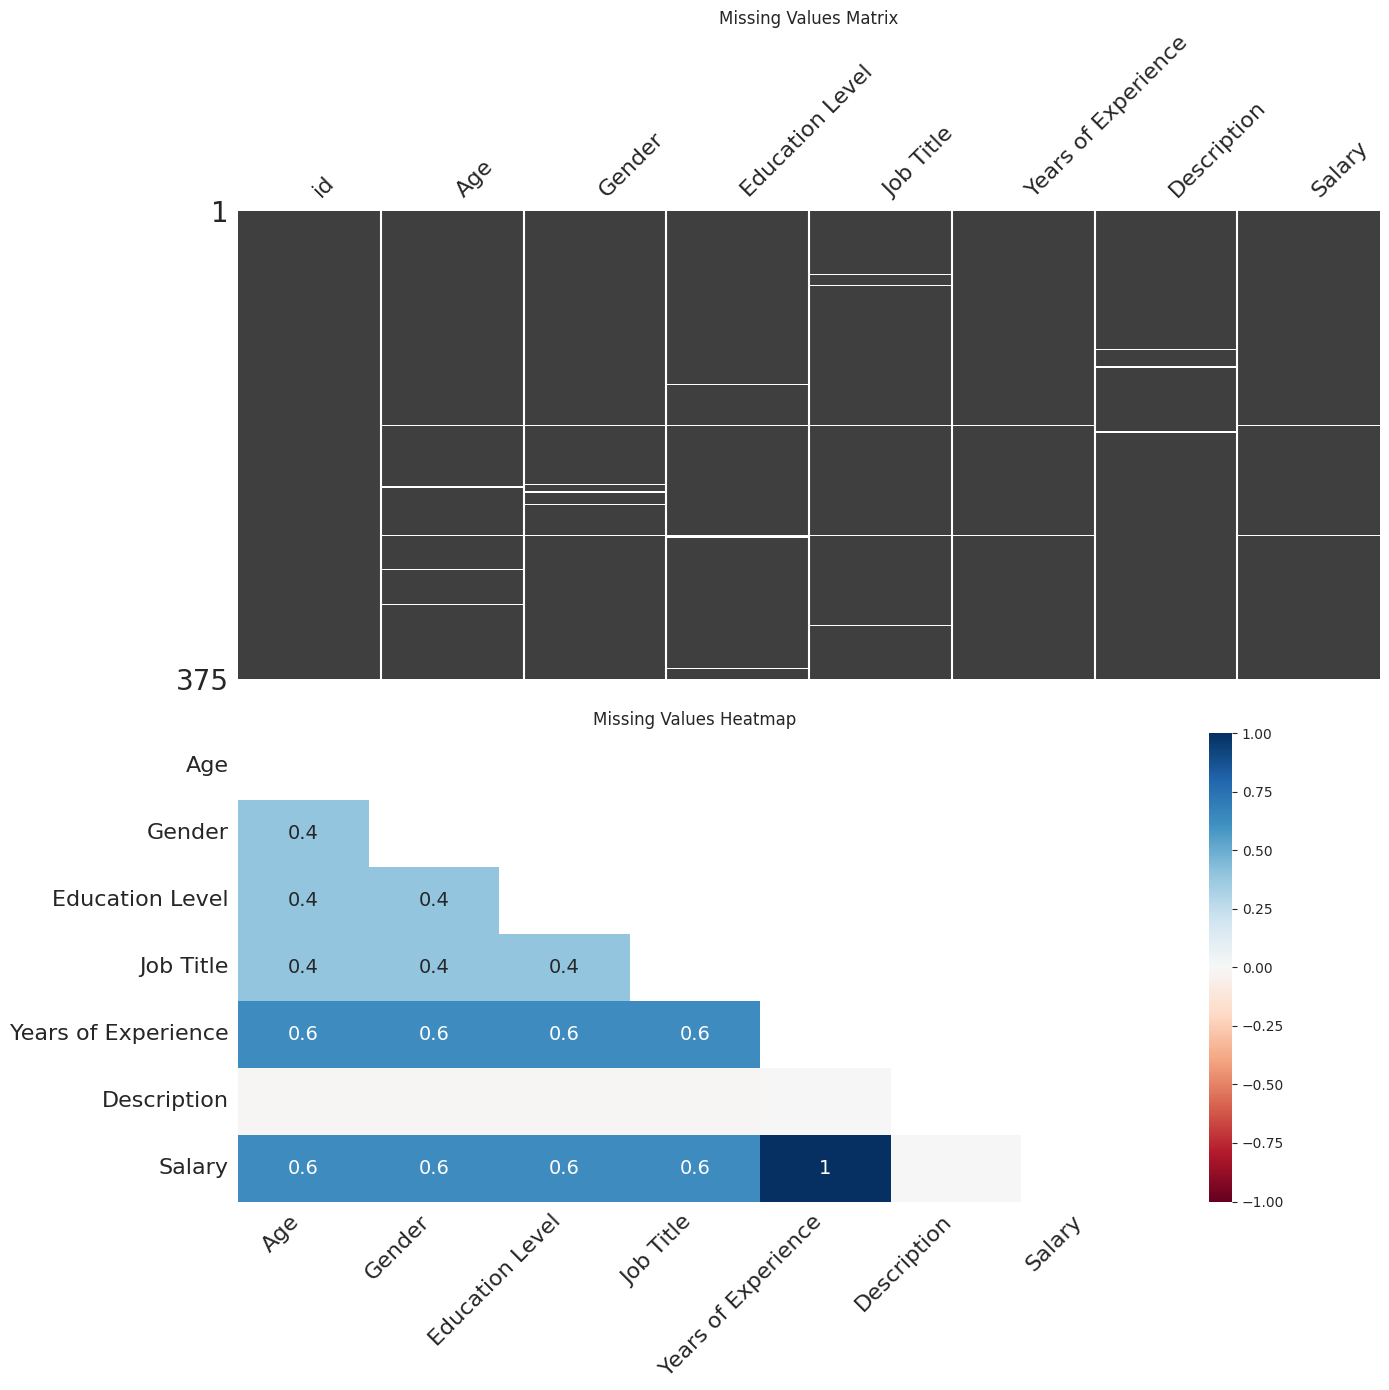

In [71]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Plot missing values matrix on the first subplot
msno.matrix(df, ax=axes[0])
axes[0].set_title("Missing Values Matrix")

# Plot missing values heatmap on the second subplot
msno.heatmap(df, ax=axes[1])
axes[1].set_title("Missing Values Heatmap")

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

**Missingno Matrix (Image 1)**  
This visualization provides a clear overview of missing data across both rows and columns. We can see that:

- Missing values appear to be sporadically distributed, with no strong concentration in any specific row or group.
- A few columns — notably **Age**, **Gender**, **Education Level**, **Job Title**, and **Description** — show minor patches of missing data.
- There’s no evidence of a systemic pattern (e.g., no subset of records consistently missing multiple fields).

The missingness appears to be **random and low in volume**, making it reasonable to proceed with dropping these rows. This approach is unlikely to introduce significant bias or affect overall data integrity.

**Missing values heatmap (Image 2)**

This shows how missingness in columns correlates with each other:
- Lighter colors indicate low or no correlation between missing values across columns.

The only notable relationship is between Salary and Years of Experience: they share a high correlation (1).

This suggests that people missing Salary are also be missing Experience — maybe new workers or entries with incomplete profiles (they are perfectly correlated in terms of absence, not in terms of their actual numerical values).

However, Salary is the target value and rows that are missing this value are not useful for training or evaluating predictive models.

Keeping these rows could introduce noise or skew analysis like correlations or distributions.

Taking all these into account, we will drop rows with NaN values on the dataframe.

In [72]:
df = df.dropna()

In [73]:
missing_data_table(df)

,NaN Count,NaN Percentage (%)
id,0,0.0
Age,0,0.0
Gender,0,0.0
Education Level,0,0.0
Job Title,0,0.0
Years of Experience,0,0.0
Description,0,0.0
Salary,0,0.0


## Outliers

In [74]:
df.describe()

,id,Age,Years of Experience,Salary
count,358.000000,358.000000,358.000000,358.000000
mean,185.946927,37.446927,10.065642,100880.865922
std,109.122371,7.090944,6.588486,48512.245167
min,0.000000,23.000000,0.000000,350.000000
25%,91.250000,31.250000,4.000000,55000.000000
50%,185.500000,36.000000,9.000000,95000.000000
75%,280.750000,44.000000,15.750000,140000.000000
max,374.000000,53.000000,25.000000,250000.000000


Select numerical and categorical columns

In [75]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns
# Drop the 'id' column
numerical_cols = numerical_cols.drop('id', errors='ignore')

# Select only categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

We will use boxplots to visually detect the presence of outliers,

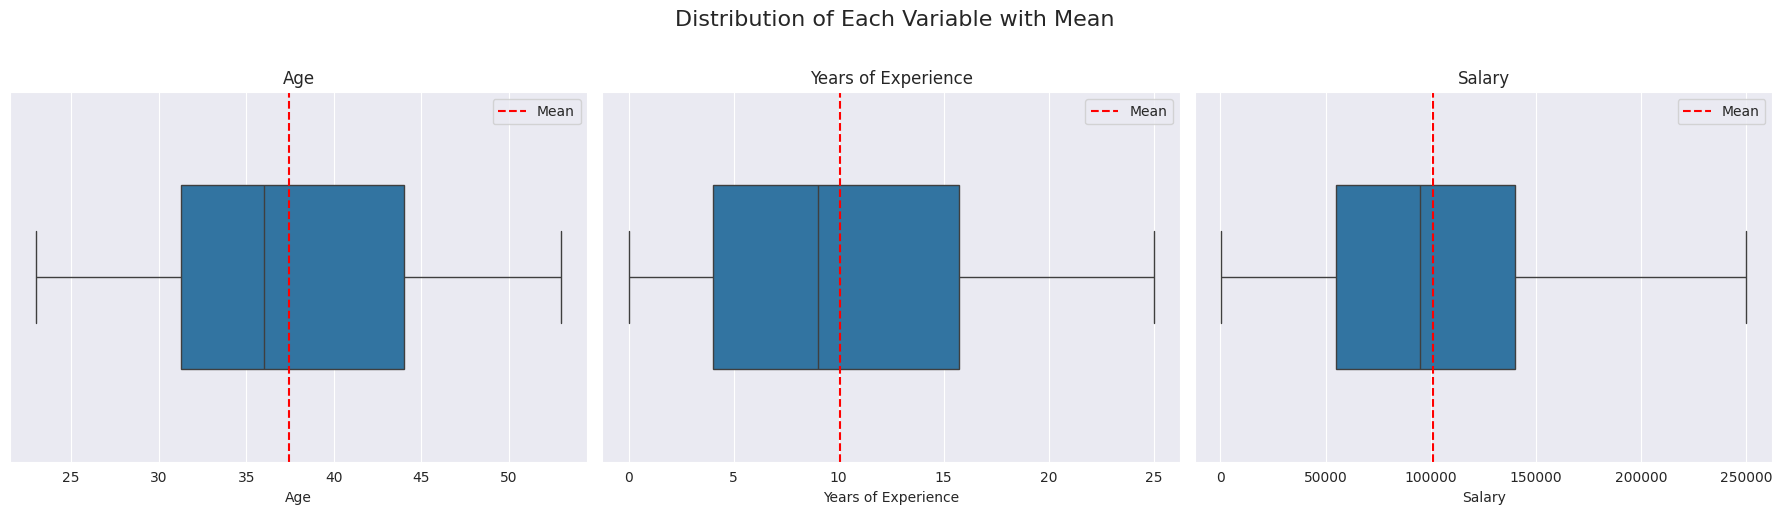

In [76]:
boxplots(df, numerical_cols)

We did not notice outliers in the numerical columns.

## Visualizing the data

We will visualize the data to explore the distribution of numerical features, identify potential outliers and variability, and examine relationships between variables, including feature correlations.

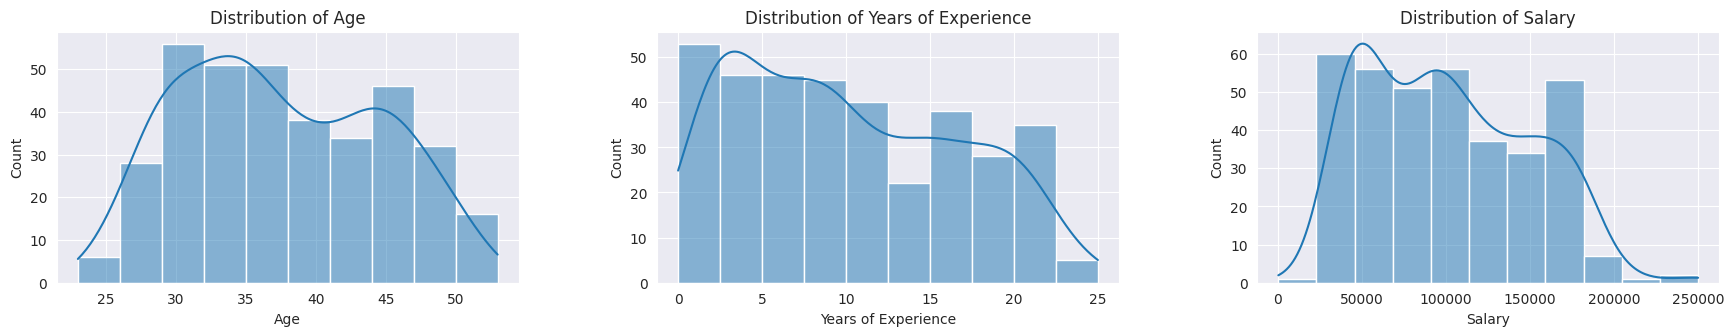

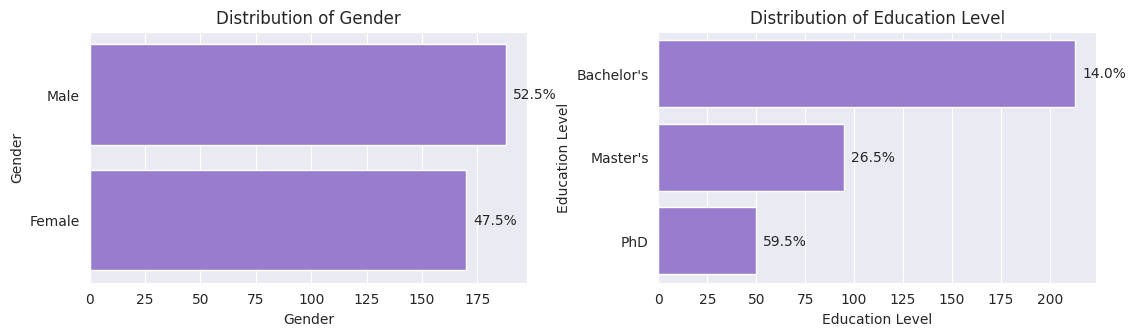

In [77]:
# Plot numerical features (histogram)
create_plots(numerical_cols, lambda col, ax: sns.histplot(df, x=col, kde=True, ax=ax))

# Plot categorical features (bar chart)
categorical_cols_for_graph = categorical_cols.drop(['Description', 'Job Title'], errors='ignore')
create_plots(
    categorical_cols_for_graph,
    lambda col, ax: (
        sns.countplot(y=col, data=df, ax=ax, color="mediumpurple"),
        ax.bar_label(
            ax.containers[0],
            labels=[
                f'{(v / df[col].notna().sum() * 100):.1f}%'
                for v in df[col].value_counts().sort_index(ascending=False).values
            ],
            padding=5,
            fontsize=10
        )
    ),
    n_cols=2,
)

### Distribution of numerical columns

#### **Age**
- The distribution is slightly right-skewed, but generally well-balanced.
- Most individuals fall between 30 and 45 years old, with a peak around the early 30s. This suggests the dataset includes a significant number of early- to mid-career professionals.
- There's a drop-off after age 50, and only a small number of entries under 25. That aligns with typical workforce demographics, where fewer very young or senior-aged professionals are present.
- This distribution seems fairly representative for industries that rely on some level of experience, though it might underrepresent entry-level or late-career professionals.

#### **Years of Experience**
- This distribution is noticeably right-skewed, with a heavy concentration in the lower range (0–10 years).
- There's a sharp peak at around 2–5 years, suggesting a large portion of the dataset includes people early in their careers.
- Beyond 15 years, the number of individuals tapers off significantly, and there are very few with more than 20 years of experience.
- This pattern likely reflects a workforce with many junior to mid-level professionals and a relatively smaller number of senior experts.
- It's also worth noting the potential for overlap between very young ages and missing experience values — this could indicate interns, students, or newly hired workers with incomplete data.


#### **Salary**
- Salary is the most skewed of the three distributions — there's a long right tail, indicating a smaller number of high earners.
- Most salaries cluster between 30,000 and 150,000, with common peaks around 50K–70K and another noticeable bump closer to 100K.
- A few entries go beyond $200,000, but these are outliers. Depending on the context of the dataset (e.g., tech, finance), these could represent executives, specialists, or outlier roles.
- This distribution might benefit from a transformation before modeling, especially if we’re using algorithms sensitive to skewed distributions.
- Since Salary is the target variable, understanding its shape helps inform how we deal with both missing values and potential outliers.



**Summary**
- These distributions give us a clearer picture of the population: largely early- to mid-career professionals with moderate salaries and limited long-term experience.
- Before modeling, we may want to:
  - **Explore correlations** between Age, Experience, and Salary.
  - **Segment by role or education** to better understand how these factors interact across groups.

### Distribution of categorical columns

#### **Gender**
- The gender distribution is fairly balanced, with:
  - 52.5% Male
  - 47.5% Female
- This slight male majority suggests no major gender imbalance, which is great from a modeling perspective—it reduces the risk of gender-related bias.

#### **Education Level**
- Education level is a bit more skewed, with the majority of individuals holding a Bachelor’s degree (59.5%).
- This is followed by:
  - Master’s degrees at 26.5%
  - PhDs at 14%
- The dominance of Bachelor’s degrees suggests the dataset leans toward entry-level or general professional roles rather than academic or specialized research positions.
- The fairly strong presence of advanced degrees (40.5% have a Master’s or PhD) still indicates a well-educated population, which might influence things like salary expectations or job responsibilities.

**Summary**
- **Gender** is close to evenly split, with a small male majority.
- **Education** is skewed toward Bachelor’s degrees, but there’s a strong representation of postgraduate qualifications.


**Notes on 'Description' and 'Job Title' Columns**

The 'Description' and 'Job Title' columns contain a large number of unique values, which makes them high-cardinality features.

- These fields are text-heavy and unstructured, especially 'Description', which might contain free-form input or role-specific notes.
- 'Job Title', although more structured, still includes a wide variety of titles, often with slight variations (e.g., "Software Engineer", "Software Developer", "Sr. Software Engineer"), which can add complexity when grouping or analyzing them.

Due to this high cardinality, these columns are not ideal for straightforward visualization or encoding without preprocessing. For now, we will be excluding them temporarily from exploratory visualizations, as they don’t lend themselves well to simple bar plots.

But later on, we may consider:
- **Standardizing job titles** (e.g., grouping by role family or level),
- **Extracting features from descriptions** (e.g., NLP techniques)

### Relationships between variables

Now, we'll observed the relationship between explanatory variables and target

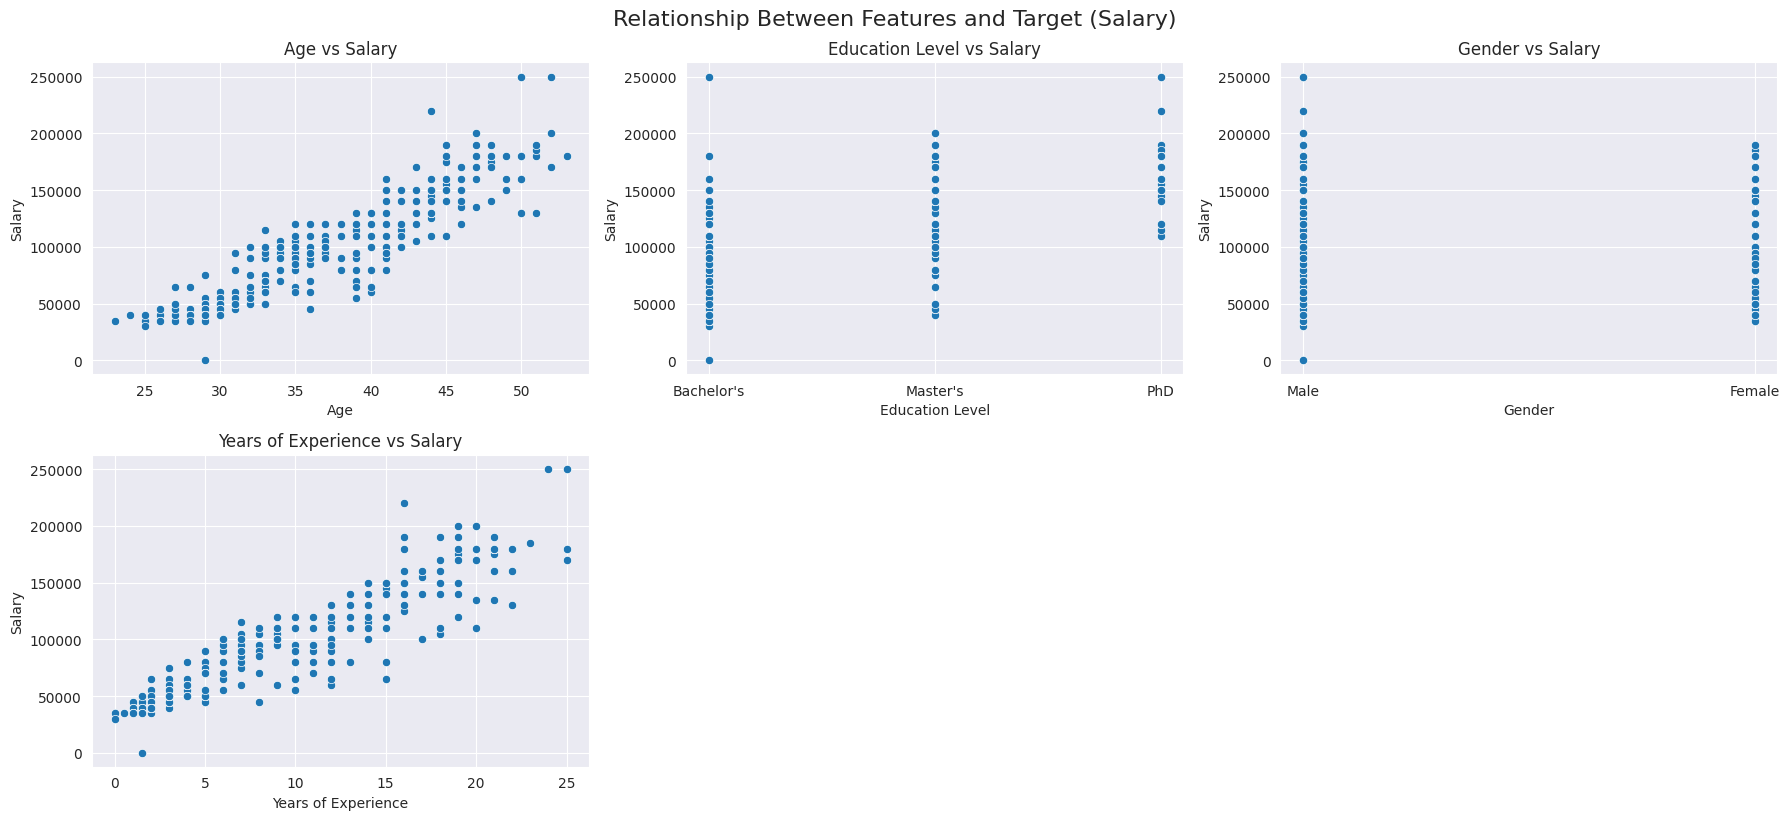

In [78]:
scatterplot(df)

This figure displays scatter plots showing how various features relate to the target variable, **Salary**.

 **Age vs. Salary** *(Top-left)*  
There is a clear positive trend, as age increases, salary tends to increase as well.  
This suggests that older individuals typically earn higher salaries, possibly due to increased experience or seniority.

 **Gender vs. Salary** *(Top-right)*  
The salary distribution between Male and Female appears relatively similar at first glance.  

 **Education Level vs. Salary** *(Bottom-left)*  
There seems to be some variation in salary across education levels:
- Individuals with a PhD often earn more, on average.
- Those with Bachelor's and Master’s degrees show a wider spread in salaries.

**Years of Experience vs. Salary** *(Bottom-right)*  
This feature shows a strong positive relationship with salary, more years of experience are generally associated with higher earnings.  
This is likely one of the most influential variables in determining salary.

Let's create some boxplots for more detail in Gender vs. Salary and Education Level vs. Salary to see these relationships with more detail.

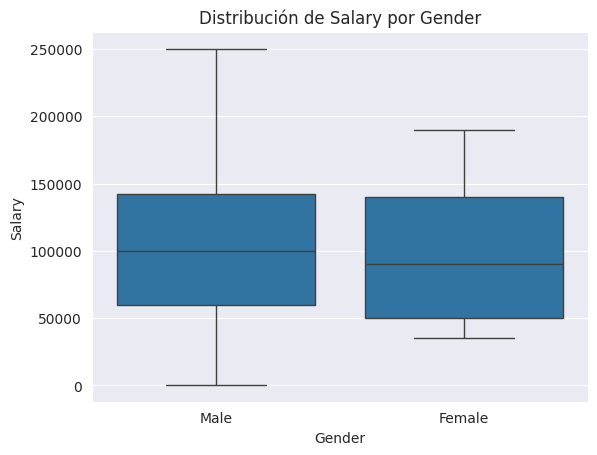

In [79]:
sns.boxplot(x='Gender', y='Salary', data=df)
plt.title('Distribución de Salary por Gender')
plt.show()

While both genders have a similar central distribution, men show slightly higher median salaries and a broader spread, especially toward the top.
This may indicate potential differences in salary ceiling, though a formal statistical test (like an independent t-test) is recommended to confirm whether the difference is significant.

An independent t-test (also called a two-sample t-test) is a statistical test used to compare the means of two independent groups to see if there's a statistically significant difference between them.

You use an independent t-test when:

- You have two groups (e.g., Male vs. Female).

- You want to compare their average values for some numeric variable (e.g., Salary).

- The groups are independent (one person can't be in both groups).

If p-value < 0.05 → There is a statistically significant difference in salaries between genders.

If p-value >= 0.05 → There is no significant evidence of a salary difference by gender.



In [80]:
# Filter salary data by gender
male_salaries = df[df['Gender'] == 'Male']['Salary']
female_salaries = df[df['Gender'] == 'Female']['Salary']

# Perform independent t-test
t_stat, p_value = ttest_ind(male_salaries, female_salaries, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 1.6247
P-value: 0.1051


Since the p-value (0.1051) is greater than 0.05, we do not have sufficient statistical evidence to conclude that there's a significant difference in salary between males and females in your dataset.

In other words, while the boxplot visually suggests that males might earn slightly more on average, the difference is not statistically significant based on this sample.

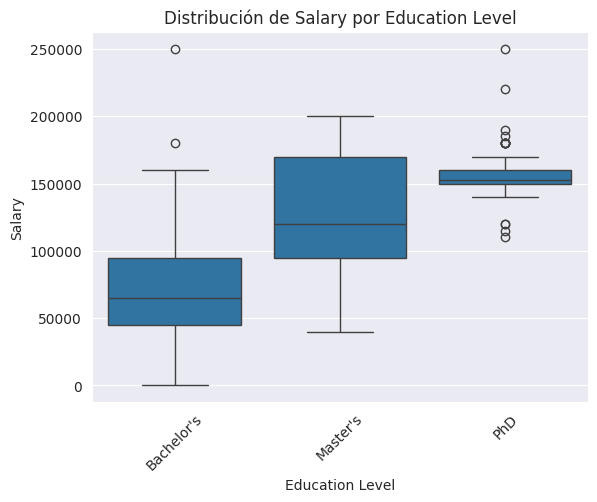

In [81]:
sns.boxplot(x='Education Level', y='Salary', data=df)
plt.title('Distribución de Salary por Education Level')
plt.xticks(rotation=45)
plt.show()

This box plot shows the distribution of salaries across different education levels—Bachelor’s, Master’s, and PhD. We see that:

Bachelor's degree holders generally earn lower salaries, with a wider range and several low-end values.

Master's degree holders show a higher median salary than Bachelor's, with a broader interquartile range (IQR), suggesting more variability in earnings.

PhD holders have consistently high salaries, with a higher minimum salary and a narrower range compared to the other two. Most salaries are tightly grouped around the upper end, though a few outliers exist.

The box plot suggests a positive relationship between education level and salary—higher education tends to correlate with higher earnings.

### Correlation matrix

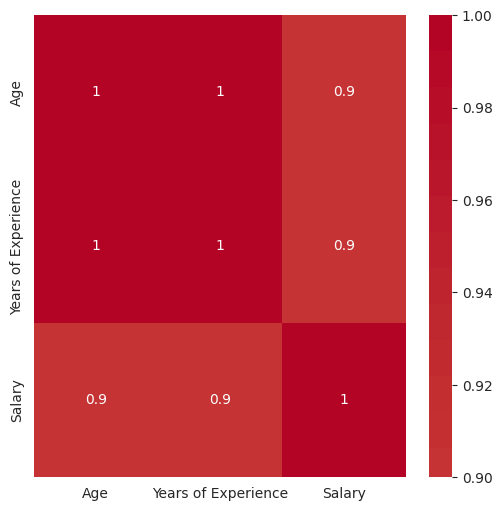

In [82]:
corr = df[numerical_cols].corr().round(1)
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.show()

All three variables are strongly positively correlated, especially Age and Experience. This is expected, as older individuals typically have more experience, and both are strongly linked to higher salaries. These strong correlations suggest a potential multicollinearity issue if all three variables are used as predictors in a regression model.

## Feature Engineer

### Train - test split

Now, we have to extract features from descriptions, but first we will split the dataset in train, test and validation datasets.

When using pretrained models like BERT for feature extraction, you’re still technically learning from the text, even if the model is frozen. If you generate embeddings on the whole dataset before splitting, there’s a risk of data leakage, especially if any of the downstream steps (e.g., dimensionality reduction, scaling, or feature selection) are also applied before splitting.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Salary']),
    df['Salary'],
    test_size=0.2,
    random_state=42
)

The FeatureEngineer class performs feature engineering by creating new, more useful features from raw data. We should use the FeatureEngineer class after splitting the data into train and test sets to avoid data leakage — that is, allowing information from the test set to influence the training process.

Even though FeatureEngineer doesn’t "learn" from the data (no .fit() logic), you should still apply it only on the training data first, then separately on the test data, to simulate real-world conditions and preserve model evaluation integrity.

The feature engineering like extracting "Seniority", "Role_family", and a new numeric feature "Exp_education", it's safe to apply before splitting the data, since this transformation is based only on existing columns (no target involved).

But the scaling and encoding (transformer) should only be fit on the training set.

In [84]:
# Inicialize pipeline
full_pipeline = build_pipeline()

# Fit only on training data
X_train_transformed = full_pipeline.fit_transform(X_train)

# Apply the fitted transformer to test
X_test_transformed = full_pipeline.transform(X_test)

### Extracting features from descriptions

Now, we will convert the raw job descriptions into semantic vectors for downstream ML tasks using a lightweight transformer model. We will use the pretrained Sentence Transformer model, 'all-MiniLM-L6-v2'. This is a fast and compact transformer model (384-dimensional embeddings).  

This way, we will:
- Transform unstructured text into machine-readable features for ML models.  
- Preserve semantic meaning (similar jobs → similar vectors).  

# Model Training and Evaluation

## Model Training

In [85]:
# Load a pretrained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small and fast, good quality

# Clean the raw text descriptions
X_train['Description_clean'] = X_train['Description'].fillna('').str.lower()
X_test['Description_clean'] = X_test['Description'].fillna('').str.lower()

# Generate embeddings
train_embeddings = model.encode(X_train['Description_clean'].tolist(), show_progress_bar=True)
test_embeddings = model.encode(X_test['Description_clean'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Combine text embeddings with the numerical and categorical features, then train a model using the full feature set.

In [86]:
# Make sure the shapes match (just for sanity)
print("Tabular shape:", X_train_transformed.shape)
print("Embeddings shape:", train_embeddings.shape)

# Combine the feature sets
X_train_final = np.hstack([X_train_transformed, train_embeddings])
X_test_final = np.hstack([X_test_transformed, test_embeddings])

Tabular shape: (286, 21)
Embeddings shape: (286, 384)


We´ll train a RandomForestRegressor model with hyperparameter optimization using optuna.

In [87]:
best_model = train_model(X_train_final, y_train)

[I 2025-04-22 15:28:17,752] A new study created in memory with name: no-name-ecdde2de-6556-4443-a0c1-c2053ece23e5
[I 2025-04-22 15:30:23,860] Trial 0 finished with value: -14026.220424320796 and parameters: {'n_estimators': 986, 'max_depth': 12, 'min_samples_split': 18}. Best is trial 0 with value: -14026.220424320796.
[I 2025-04-22 15:32:22,210] Trial 1 finished with value: -14020.506068580366 and parameters: {'n_estimators': 959, 'max_depth': 13, 'min_samples_split': 19}. Best is trial 1 with value: -14020.506068580366.
[I 2025-04-22 15:33:33,117] Trial 2 finished with value: -13939.724527284276 and parameters: {'n_estimators': 499, 'max_depth': 6, 'min_samples_split': 10}. Best is trial 2 with value: -13939.724527284276.
[I 2025-04-22 15:35:27,649] Trial 3 finished with value: -13935.166447224114 and parameters: {'n_estimators': 753, 'max_depth': 13, 'min_samples_split': 9}. Best is trial 3 with value: -13935.166447224114.
[I 2025-04-22 15:37:00,067] Trial 4 finished with value: -13

## Model Evaluation

As we want to report the metrics as intervals, we will use the function bootstrap_metrics, that is used to estimate confidence intervals for your model's performance metrics using a technique called bootstrapping.
This works by doing resamples the original prediction results (with replacement) many times (by default, 1000).

For each resampled set, it computes:

RMSE (Root Mean Squared Error)

MAE (Mean Absolute Error)

R² Score

Finally, it returns the 2.5th and 97.5th percentiles for each metric. This gives a 95% confidence interval, showing the expected variability in model performance.

Why each metric is used:
1. RMSE (Root Mean Squared Error)
- Measures the average magnitude of the error, penalizing larger errors more heavily due to the square.
- Is useful when you want to be stricter with large deviations.
- Units are the same as the target variable (e.g., salary).

2. MAE (Mean Absolute Error)
- Measures the average absolute difference between predictions and true values.

- More robust to outliers than RMSE, since it doesn’t square the errors.

3. R² Score (Coefficient of Determination)
- Represents the proportion of variance explained by the model.

- Ranges from 0 (no predictive power) to 1 (perfect prediction), can also be negative for bad models.

We use all three together for a well-rounded view.

For comparing with a baseline like a DummyRegressor, we use RMSE and MAE.
These show how much better your model predicts compared to simply guessing the average. If your RMSE and MAE are significantly lower than the baseline’s, your model is learning real patterns.


The DummyRegressor(strategy='mean') always predicts the same value: the mean of the training set wages.

In [88]:
# Predicted values based on the test set
y_test_pred = best_model.predict(X_test_final)

# Bootstrapped 95% CI for RMSE, MAE, and R²
model_ci = bootstrap_metrics(y_test.values, y_test_pred)

print("Final Model - 95% Confidence Intervals:")
print(f"RMSE: {model_ci[0][0]:.2f} to {model_ci[1][0]:.2f}")
print(f"MAE:  {model_ci[0][1]:.2f} to {model_ci[1][1]:.2f}")
print(f"R²:   {model_ci[0][2]:.3f} to {model_ci[1][2]:.3f}")

Final Model - 95% Confidence Intervals:
RMSE: 10507.51 to 26616.92
MAE:  7678.65 to 14530.77
R²:   0.767 to 0.952


Using bootstrapping (1,000 resamples), we estimated the uncertainty around our model's evaluation metrics. The results are as follows:

RMSE (Root Mean Squared Error):
This indicates that, on average, the model's prediction error ranges within this window, with larger errors being more heavily penalized.

MAE (Mean Absolute Error):
This tells us that, across multiple samples, the model's average error in absolute terms (regardless of direction) falls in this range. It tells you: “On average, how far off is my prediction?”

R² (Coefficient of Determination):
This suggests that the model explains between 76.7% and 95.2% of the variance in the target variable, showing a high and stable level of predictive power across different bootstrapped samples.



Compare with baseline

In [89]:
evaluate_model_with_baseline(best_model, X_train_final, y_train, X_test_final, y_test)

Final Model - 95% Confidence Intervals:
RMSE: 10526.69 to 27367.28
MAE:  7725.17 to 14580.45
R²:   0.752 to 0.951

 Baseline DummyRegressor - 95% Confidence Intervals:
RMSE: 45057.24 to 58240.67
MAE:  38567.36 to 50186.34
R²:   -0.173 to -0.000



Metric-by-Metric Comparison

- Root Mean Squared Error (RMSE)

RMSE emphasizes large errors by squaring them, making it a good metric for penalizing big misses. The trained model shows a clear reduction in RMSE, meaning it consistently produces salary estimates much closer to the real values than the baseline.


- Mean Absolute Error (MAE)

MAE reflects the average size of errors without giving more weight to larger ones. The trained model's MAE is less than half that of the baseline, confirming that its predictions are not only more accurate on average but also more consistent and less prone to major deviations.

- R² Score (Coefficient of Determination)**

R² indicates how much of the variance in salaries the model can explain. The baseline's R² is near zero or even negative—meaning it doesn't explain the data at all. On the other hand, the trained model explains **75% to 95%** of the variance, a strong indication of meaningful learning and solid predictive performance.

**Conclusion**

Across all metrics the trained model delivers a much stronger performance than the baseline. The improvement is both statistically significant and practically meaningful.

These results suggest that the model is well-calibrated, robust, and likely to generalize well to unseen data. It's a reliable step forward for any task involving salary prediction and shows that your feature engineering and modeling pipeline are effectively capturing the underlying structure of the problem.

# Results Visualization

In [ ]:
!pip install shap

## SHAP Feature Importance Analysis

We will performs SHAP (SHapley Additive exPlanations) analysis to interpret how each feature contributes to the predictions of your machine learning model. SHAP values help explain the impact of individual features, making the model's decisions more transparent.



In [ ]:
# Drop auxiliar columns
columns_to_drop = ['Description', 'Description_clean']
existing_columns = [col for col in columns_to_drop if col in X_test.columns]
X_test_filtered = X_test.drop(columns=existing_columns, errors='ignore')

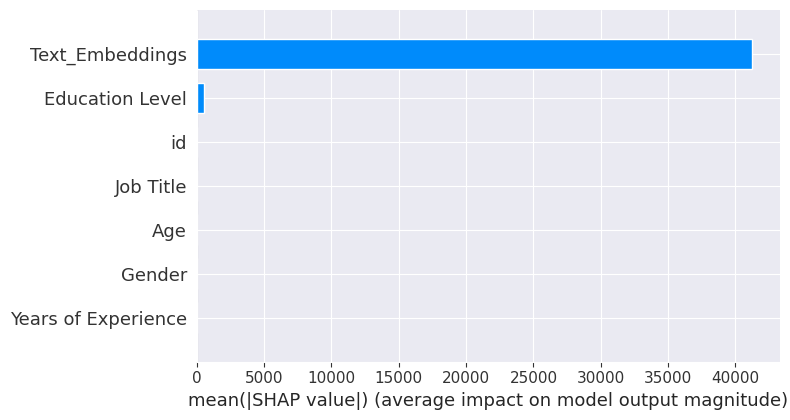

In [92]:
plot_shap_feature_importance(best_model, X_test_final, X_test_filtered)

The SHAP summary plot reveals the relative contribution of each feature to the model’s predictions. The most dominant feature by far is Text_Embeddings, indicating that the semantic information captured from job descriptions plays the largest role in predicting salary. This suggests that the model heavily relies on the contextual understanding of the job postings, as encoded by the embeddings.

The next most influential feature, albeit much less significant, is Education Level, Description, and Age. Features such as Gender, Years of Experience, and Job Title appear to have negligible influence on the model's output.

This outcome highlights the power of text embeddings in capturing complex patterns from unstructured data, often surpassing the predictive value of traditional categorical or numerical variables. However, it also underscores the importance of ensuring high-quality and representative text data, as the model’s performance is highly dependent on it.


## Prediction vs Actual Plot

This plot shows the relationship between the actual salaries from the test set (y_test) and the salaries predicted by the model (y_test_pred). Each point represents a single prediction. Ideally, if the model were perfect, all points would lie exactly on the diagonal dashed line, where the predicted salary equals the actual salary.

The dashed line serves as a reference for perfect predictions. The closer the points are to this line, the more accurate the predictions. If points are spread far from the line, it indicates prediction errors. This kind of plot is useful for visually assessing the performance of a regression model and spotting potential patterns of over- or underestimation.

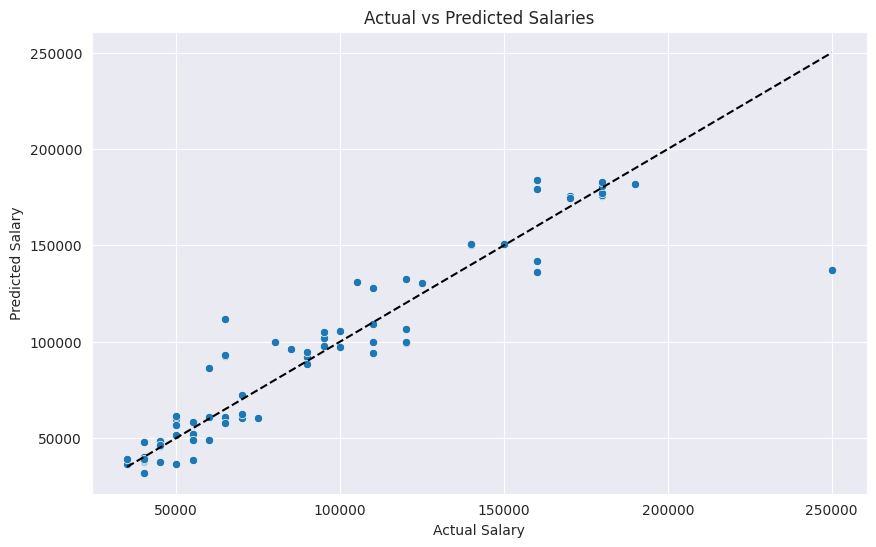

In [93]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salaries')
plt.show()

The scatter plot comparing actual versus predicted salaries indicates that the model performs reasonably well overall. Most predictions fall close to the ideal diagonal line, suggesting that the model has successfully captured the general relationship between the input features and the target variable (salary). This alignment reflects a good fit across much of the salary range.

However, some patterns are worth noting. At higher salary levels, predictions tend to become more dispersed and occasionally fall below the actual values. This suggests that the model may struggle slightly with accurately predicting very high salaries, potentially underestimating them. This behavior is common when there are fewer high-salary examples in the training data or when the model is not complex enough to fully capture non-linear patterns in the data.

In summary, the model is making accurate predictions for the majority of cases, especially within the mid-range of salaries, but there may be room for improvement in capturing the behavior of high-income roles, for example, addressing class imbalance could help mitigate these issues.

Let´s save the trained model and preprocessing pipeline

In [94]:
import joblib
joblib.dump(best_model, 'salary_model.pkl')
joblib.dump(full_pipeline, 'preprocessing_pipeline.pkl')

['preprocessing_pipeline.pkl']